<a href="https://colab.research.google.com/github/shrey-001/Image-Semantic-Segmentation-Using-U-net/blob/main/unet-using-Conv2dTranspose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import tensorflow as tf

import keras
from keras.layers import *
from keras.models import Sequential  
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
import cv2

import time
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip "/content/drive/MyDrive/U-net/u-net.zip" -d "/content/Data"

Archive:  /content/drive/MyDrive/U-net/u-net.zip
   creating: /content/Data/test/
  inflating: /content/Data/test/100032540_1_image.jpg  
  inflating: /content/Data/test/100032540_1_label.png  
  inflating: /content/Data/test/1012675629_2_image.jpg  
  inflating: /content/Data/test/1012675629_2_label.png  
  inflating: /content/Data/test/1018882799_1_image.jpg  
  inflating: /content/Data/test/1018882799_1_label.png  
  inflating: /content/Data/test/1019068877_1_image.jpg  
  inflating: /content/Data/test/1019068877_1_label.png  
  inflating: /content/Data/test/1021890651_1_image.jpg  
  inflating: /content/Data/test/1021890651_1_label.png  
  inflating: /content/Data/test/1030333538_1_image.jpg  
  inflating: /content/Data/test/1030333538_1_label.png  
  inflating: /content/Data/test/1033312112_1_image.jpg  
  inflating: /content/Data/test/1033312112_1_label.png  
  inflating: /content/Data/test/103770709_1_image.jpg  
  inflating: /content/Data/test/103770709_1_label.png  
  inflatin

In [22]:
train_path="/content/Data/train"
test_path="/content/Data/test"

In [23]:
train_file=sorted(os.listdir(train_path))
test_file=sorted(os.listdir(test_path))

In [24]:
len(train_file)

3998

In [25]:
train_dataset=train_file[:3600]
val_dataset=train_file[3600:]

In [26]:
print(len(train_dataset)/2)
print(len(val_dataset)/2)

1800.0
199.0


In [27]:
def load_data(dataset_list):
  images=[]
  labels=[]
  for i in dataset_list:
    if i.endswith("_label.png"):
      labels.append(i)
    if i.endswith("_image.jpg"):
      images.append(i)
  return sorted(images),sorted(labels)

In [28]:
train_image_dataset,train_labels_dataset=load_data(train_dataset)
val_image_dataset,val_labels_dataset=load_data(val_dataset)

In [29]:
X_train=np.zeros((len(train_image_dataset),316,316,1),dtype='float32')
y_train=np.zeros((len(train_image_dataset),132,132,11),dtype='uint8')

X_val=np.zeros((len(val_image_dataset),316,316,1),dtype='float32')
y_val=np.zeros((len(val_image_dataset),132,132,11),dtype='uint8')

In [30]:
def load_image(path2):
  image=cv2.imread(train_path+'/'+path2,cv2.IMREAD_GRAYSCALE)
  image=cv2.resize(image,(316,316),interpolation=cv2.INTER_NEAREST)
  image=image/255.0
  image=cv2.normalize(image,None)
  image=np.expand_dims(image,axis=2)
  image=image.astype(np.float32)
  return image

In [31]:
def load_label(path2):
  
  labels=cv2.imread(train_path+'/'+path2, cv2.IMREAD_GRAYSCALE)
  labels=tf.keras.utils.to_categorical(labels,num_classes=11,dtype='uint8')
  labels_stack_sm = np.zeros((132, 132,11),dtype='uint8')
  for id in range(11):
    img = labels[ :, :,id]
    img_sm = cv2.resize(img, (132, 132), interpolation=cv2.INTER_NEAREST)
    labels_stack_sm[:, :,id] = img_sm
  return labels_stack_sm

In [32]:
from tqdm import tqdm
for i in tqdm(range(1800)):
  X_train[i ,: ,: ,: ] = load_image(train_image_dataset[i])
  y_train[i ,: ,: ,: ] = load_label(train_labels_dataset[i])
for i in tqdm(range(199)):
  X_val[i ,: ,: ,: ] = load_image(val_image_dataset[i])
  y_val[i ,: ,: ,: ] = load_label(val_labels_dataset[i])

100%|██████████| 199/199 [00:04<00:00, 43.59it/s]


Input Pipeline




In [33]:
BATCH_SIZE = 4
SHUFFLE_BUFFER_SIZE = 1000
train = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train = train.shuffle(SHUFFLE_BUFFER_SIZE)
train = train.batch(BATCH_SIZE)
train = train.prefetch(1)

val = tf.data.Dataset.from_tensor_slices((X_val,y_val))
val = val.batch(BATCH_SIZE)
val = val.prefetch(1)


Model Training


In [35]:
input_size = (316,316,1)
inputs = Input(input_size)

conv1 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu',kernel_initializer='he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu',kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu',kernel_initializer='he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu',kernel_initializer='he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu',kernel_initializer='he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu',kernel_initializer='he_normal')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, 3, activation = 'relu',kernel_initializer='he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu',kernel_initializer='he_normal')(conv5)
    

up6 = Conv2DTranspose(512, 2, activation = 'relu',strides=(2, 2),kernel_initializer='he_normal')(conv5)
crop4=Cropping2D(cropping=((4, 4), (4, 4)))(conv4)
merge6 = concatenate([crop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu',kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu',kernel_initializer='he_normal')(conv6)


up7 = Conv2DTranspose(256, 2, activation = 'relu',strides=(2, 2),kernel_initializer='he_normal')(conv6)
crop3=Cropping2D(cropping=((16, 16), (16, 16)))(conv3)
merge7 = concatenate([crop3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu',kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu',kernel_initializer='he_normal')(conv7)

up8 = Conv2DTranspose(128, 2, activation = 'relu',strides=(2, 2),kernel_initializer='he_normal')(conv7)
crop2=Cropping2D(cropping=((40, 40), (40, 40)))(conv2)
merge8 = concatenate([crop2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu',kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu',kernel_initializer='he_normal')(conv8)

up9 = Conv2DTranspose(64, 2, activation = 'relu',strides=(2, 2),kernel_initializer='he_normal')(conv8)
crop1=Cropping2D(cropping=((88, 88), (88, 88)))(conv1)
merge9 = concatenate([crop1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal')(conv9)

#conv9 = Conv2D(2, 3, activation = 'relu',padding='same',kernel_initializer='he_normal')(conv9)
conv10 = Conv2D(11, 1, activation = 'sigmoid')(conv9)

model = Model(inputs,conv10)

model.compile(optimizer = keras.optimizers.Adam(lr=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 316, 316, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 314, 314, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 312, 312, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 156, 156, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [36]:
EPOCHS = 30

checkpoint_path ="/content/drive/MyDrive/U-net/drop_check/weights-conv2dTranspose.{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,monitor="val_accuracy", verbose=1, save_best_only=True, mode='auto',save_freq="epoch")
history=model.fit(train,validation_data=val,epochs=EPOCHS,callbacks=[checkpoint])

Epoch 1/30
450/450 [==============================] - 129s 201ms/step - loss: 0.2349 - accuracy: 0.5809 - val_loss: 0.1302 - val_accuracy: 0.7168

Epoch 00001: val_accuracy improved from -inf to 0.71679, saving model to /content/drive/MyDrive/U-net/drop_check/weights-conv2dTranspose.01.h5
Epoch 2/30
450/450 [==============================] - 87s 192ms/step - loss: 0.1464 - accuracy: 0.6708 - val_loss: 0.1183 - val_accuracy: 0.7168

Epoch 00002: val_accuracy improved from 0.71679 to 0.71680, saving model to /content/drive/MyDrive/U-net/drop_check/weights-conv2dTranspose.02.h5
Epoch 3/30
450/450 [==============================] - 86s 191ms/step - loss: 0.1355 - accuracy: 0.6808 - val_loss: 0.1095 - val_accuracy: 0.7542

Epoch 00003: val_accuracy improved from 0.71680 to 0.75424, saving model to /content/drive/MyDrive/U-net/drop_check/weights-conv2dTranspose.03.h5
Epoch 4/30
450/450 [==============================] - 86s 190ms/step - loss: 0.1254 - accuracy: 0.7121 - val_loss: 0.1114 - va

In [37]:
model.save("/content/drive/MyDrive/U-net/drop_check/weights-conv2dTranspose-30.h5")

In [38]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

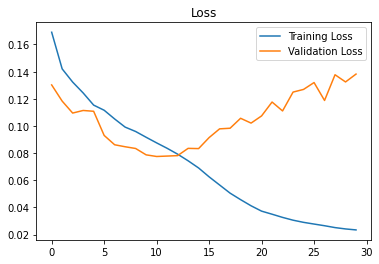

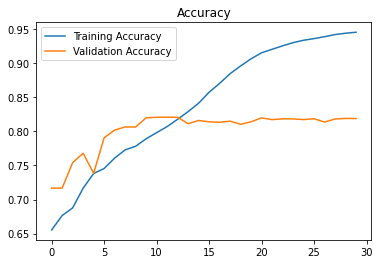

In [39]:
history = history.history
plot_metrics(history)

In [ ]:
test_image=load_image2("1012675629_2_image.jpg")
test_label=load_label2("1012675629_2_label.png")
xx=[]
yy=[]

xx.append(test_image)
xx=np.array(xx)

yy.append(test_label)
yy=to_categorical(yy,11)

In [ ]:
model.evaluate(xx,yy)

In [ ]:
pre=model.predict(xx)

In [ ]:
pre=np.argmax(pre,axis=3)

In [ ]:
np.unique(pre)